<a href="https://colab.research.google.com/github/mebirtukan/Event_detection/blob/main/IVT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import  TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, cohen_kappa_score



In [ ]:
!wget www.kasprowski.pl/datasets/events.zip
!unzip events.zip > xx

--2022-07-28 10:02:03--  http://www.kasprowski.pl/datasets/events.zip
Resolving www.kasprowski.pl (www.kasprowski.pl)... 94.152.164.213
Connecting to www.kasprowski.pl (www.kasprowski.pl)|94.152.164.213|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2909538 (2.8M) [application/zip]
Saving to: ‘events.zip’

events.zip          100%[===================>]   2.77M  2.94MB/s    in 0.9s    

2022-07-28 10:02:05 (2.94 MB/s) - ‘events.zip’ saved [2909538/2909538]



In [ ]:
def openfile(filename):
  mat = loadmat(filename)
  mdata = mat['ETdata']
  mtype = mdata.dtype
  ndata = {n: mdata[n][0,0] for n in mtype.names}
  data_headline = ndata['pos']
  data_headline = data_headline[0]
  data_raw = ndata['pos']
  pdata = pd.DataFrame(data_raw,columns=data_headline)
  df=pd.DataFrame(pdata)
  df[1.0]=df[1.0].astype(int)
  #t=pdata.iloc[:, 0].values maybe we shoud use it...
  x=pdata.iloc[:, 3:5].values
  y=pdata.iloc[:, 5].values
  print("File",filename,"opened")
  return x ,y

In [ ]:
## we don't use it here for now
def open_list_of_files(files_to_load):
  samples = []
  labels =[]
  for my_file in files_to_load:
    sam,lab = openfile(my_file)
    #ssam,slab = make_sequences(sam,lab,50)
    print('Number of samples so far:',len(samples))
    samples.extend(sam)
    labels.extend(lab)
  samples = np.array(samples)
  labels = np.array(labels)
  print('Number of samples at the end:',len(samples))
  return samples,labels
files_to_load = ['data/UH33_img_vy_labelled_MN.mat','data/UH47_img_Europe_labelled_RA.mat','data/UH21_img_Rome_labelled_MN.mat']
#files_to_load = ['data/TH34_img_Europe_labelled_MN.mat', 'data/UH21_img_Rome_labelled_RA.mat', 'data/UH47_img_Europe_labelled_MN.mat', 'data/UH27_img_vy_labelled_MN.mat']

#s,l = open_list_of_files(files_to_load)
x,y=open_list_of_files(files_to_load)
#print(x.shape)
#print(y.shape)
#print(s1.shape)
#print(l1.shape)

File data/UH33_img_vy_labelled_MN.mat opened
Number of samples so far: 0
File data/UH47_img_Europe_labelled_RA.mat opened
Number of samples so far: 4988
File data/UH21_img_Rome_labelled_MN.mat opened
Number of samples so far: 6985
Number of samples at the end: 11973


In [ ]:
#len(y1)

In [ ]:
x,y=openfile('data/UH21_img_Rome_labelled_RA.mat')

#x,y=openfile('UH21_video_BergoDalbana_labelled_MN.mat')
#x,y=openfile('UH29_video_dolphin_fov_labelled_RA.mat')
#x,y=openfile('data/UH33_img_vy_labelled_MN.mat')
#x,y=openfile('data/UH29_video_dolphin_fov_labelled_RA.mat')

File data/UH21_img_Rome_labelled_RA.mat opened


In [ ]:
import csv
import numpy as np

# we assume that the frequency is 500Hz so there is 2ms gap between every two samples
def ivt(data,v_threshold,verbose=0):
  Xs = data[:,[0]]
  Ys = data[:,[1]]

  diffX = [] #x values difference
  diffY = [] #y values difference 

  for i in range(len(data) - 1):
    diffX.append(float(Xs[i+1]) - float(Xs[i]) )
    diffY.append(float(Ys[i+1]) - float(Ys[i]) )
  distance = np.sqrt(np.power(diffX,2) + np.power(diffY,2))
  velocity = np.divide(distance,2) # 2ms gap!
  velocity = np.absolute(velocity)
  mvmts = []  
  #store 1 in mvmts[] if velocity is less than threshold else store 2
  for v in velocity:
    if(v<v_threshold):
        mvmts.append(1)
    else:
        mvmts.append(2)


  if verbose==1: ## to show charts
    print(('minimum_velocity=',min(velocity)))
    print(('maximum_velocity=',max(velocity)))
    plt.plot(velocity)
    plt.xlabel("Time [ms]")
    plt.ylabel("Velocity [px/ms]")
    plt.plot([0,len(velocity)],[v_threshold,v_threshold])
    #plt.plot([number * 10 for number in mvmts])
    plt.show()
    plt.ylim(0,5)
    plt.plot(velocity)
    #plt.plot([number for number in mvmts])
    plt.xlabel("Time [ms]")
    plt.ylabel("Velocity [px/ms]")
    plt.plot([0,len(velocity)],[v_threshold,v_threshold])
  return mvmts,velocity


('minimum_velocity=', 0.0014508618128597575)
('maximum_velocity=', 25.970265059727453)


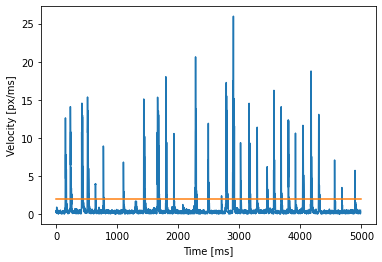

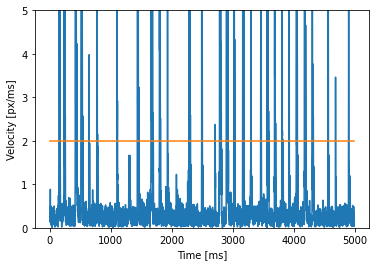

In [ ]:
# Visualisation of v_threshold
y1=ivt(x, v_threshold=2,verbose=1)

In [ ]:
thresholds=[x/10 for x in range(0,50)]

from sklearn.metrics import classification_report,accuracy_score, confusion_matrix, precision_score, cohen_kappa_score, recall_score
fixation_accuracy=[]
saccade_accuracy=[]

for t in thresholds:
  y1=ivt(x, v_threshold=t)[0]
  y_pred=np.array(y1)
  y_real=(y[:-1])
  cm=confusion_matrix(y_real, y_pred)
  # print(cm)
  #Fixation accuracy calculation
  sumf=cm[0][0]+cm[0][1]
  Tc=cm[0][0]
  fixation_accuracy.append(Tc*100/sumf)
  #Saccade accuracy calculation
  sums=cm[1][0]+cm[1][1]
  Tcs=cm[1][1]
  saccade_accuracy.append(Tcs*100/sums)

  

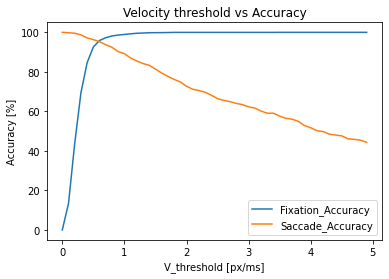

In [ ]:
plt.plot(thresholds, fixation_accuracy, label="Fixation_Accuracy")
plt.plot(thresholds, saccade_accuracy, label="Saccade_Accuracy")
#plt.plot(thresholds, accuracy, label="Acuracy")
plt.xlabel("V_threshold [px/ms]")
plt.ylabel("Accuracy [%]")
plt.title("Velocity threshold vs Accuracy")
plt.legend()
plt.show()

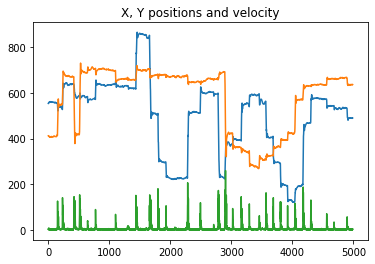

In [ ]:
y1,vel =ivt(x, v_threshold=2000)
plt.plot(x)
plt.plot([n*10 for n in vel])
#plt.plot(dx[:600])
#plt.plot(dy[:6000])
#plt.xlabel("V_threshold")
#plt.ylabel("Accuracy")
plt.title("X, Y positions and velocity")
#plt.legend()
plt.show()